# Mini-Challenge 1: Activity Recognition with MLP

This mini-challenge deals with training a Deep Neural Network to recognize activities of subjects measured via a smartphone. Thus, this is a supervised learning problem. The dataset contains time series data. This mini-challenge attempts to achieve a passable result using an MLP Deep Neural Network, although other architectures such as RNN or CNN should be better suited for this purpose.

The data is obtained from https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones.

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

## Data Download

First I download the data with a GET request from the URL. It is a `.zip` file, which is then unpacked in the folder `data`.

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

In [2]:
def download_data():
    if not os.path.isdir('./data'):
        zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
        with urlopen(zipurl) as zipresp:
            with ZipFile(BytesIO(zipresp.read())) as zfile:
                zfile.extractall('./data')
download_data()

## Data Loader

Now the data must be loaded from the folders. The files are stored in different `INPUT_SIGNAL_TYPES.txt`, already divided into train and test set. The labels are coded with 1-6 in `y_train/test.txt`. The different sensor signals `INPUT_SIGNAL_TYPES` have been stored each in 50 Hz with a time window of 2.56 s. This results in a vector of length 128 for one time window. Thus, the data set is 3-dimensional and is loaded in a `numpy.array` as a tensor. There are 7352 time windows with 128 measured values each of 9 different signal types available.

In [3]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

DATASET_PATH = './data/UCI HAR Dataset'
activity_labels = {i:label for i,label in enumerate(LABELS)}

In [4]:
def load_y(y_path):
    """Source: https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition"""
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for 0-based indexing
    return y_ - 1

def load_X(X_signals_paths):
    """Source: https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition"""
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 0, 2))
    #return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [DATASET_PATH + '/train/Inertial Signals/' + signal + 'train.txt' for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths = [DATASET_PATH + '/test/Inertial Signals/' + signal + 'test.txt' for signal in INPUT_SIGNAL_TYPES]
y_train_path = DATASET_PATH + '/train/y_train.txt'
y_test_path = DATASET_PATH + '/test/y_test.txt'

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

## Additional Parameters

Here I defined some parameters which can be used repeatedly during the Mini-Challenge.

In [5]:
# Input Data
training_data_count = len(X_train)  # 7352 training series
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0][0])  # 128 input parameters per timestep
n_input = len(X_train[0])  # 9 timesteps per series
n_flatten = n_steps * n_input # 1152 input values
n_output = np.unique(y_train).shape[0] # 6 labels

## Data Analysis

First, I examine the time frames of a particular signal type per label to analyze the scaling differences of the different labels of a sensor. Since I only want to show the scaling differences, the visualization of only one input signal is sufficient.

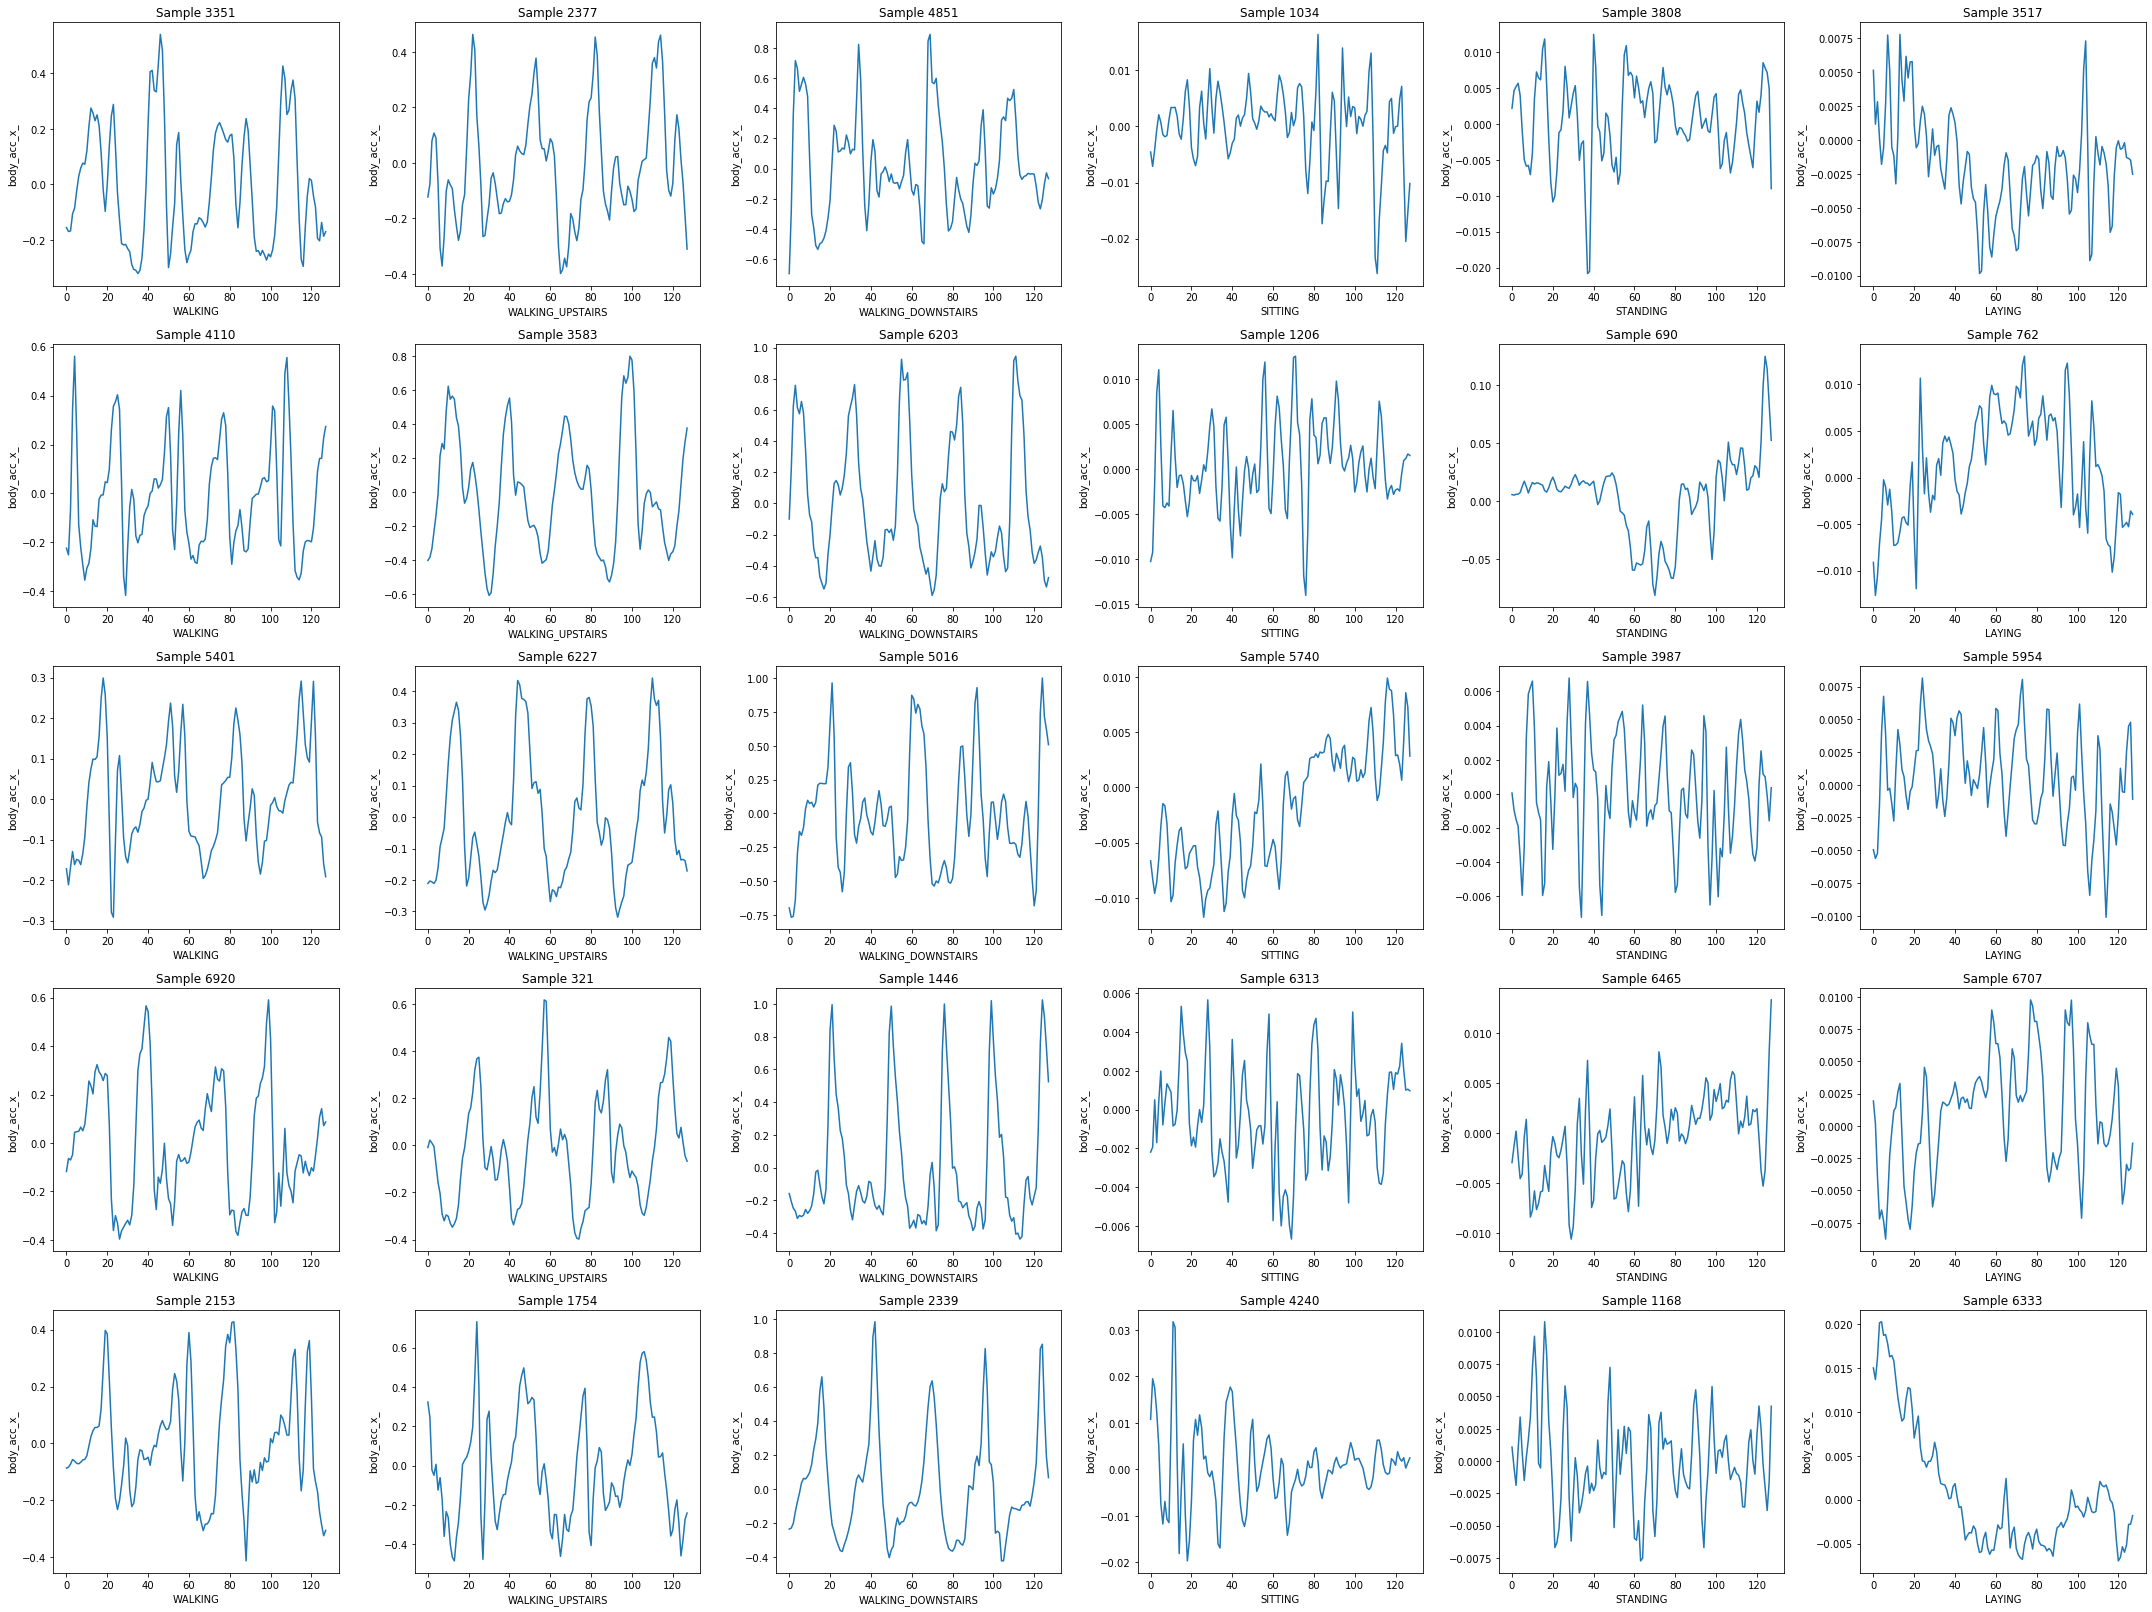

In [6]:
def plot_signal(X, y, activity_labels, input_signal_type, seed=None):
    np.random.seed(seed)
    signal_types = {signal:ix for ix, signal in enumerate(INPUT_SIGNAL_TYPES)}
    signal_type_ix = signal_types[input_signal_type]
    n_samples_per_label = 5
    ix = {}
    for i in activity_labels.keys():
        ixs_i = np.where(y == i)[0]
        ix[i] = np.random.choice(ixs_i, size=n_samples_per_label, replace=False)
    
    ix_row = np.arange(0, n_samples_per_label)
    ix_col = np.arange(0, len(activity_labels)) # labels [0-5]
    fig, ax = plt.subplots(ix_row.shape[0], ix_col.shape[0], figsize=(30,22.5))
    
    for i in ix_row:
        for j in ix_col:
            ax[i,j].plot(X[ix[j][i],signal_type_ix,:])
            ax[i,j].set(xlabel=activity_labels[j], ylabel=input_signal_type, title='Sample '+str(ix[j][i]))

    plt.tight_layout()
    plt.show()

plot_signal(X_train, y_train, activity_labels, INPUT_SIGNAL_TYPES[0], seed=42)

It can be seen that the scaling differences within the specific labels are mostly not too large (comparison signal intensity vertical). However, if we compare the intensities between the labels (comparison signal intensity horizontal), sometimes extreme differences are visible.

Now I want to have a look at the mean and variances of the different labels to decide, what kind of preprocessing I choose to perform.

In [7]:
def calc_stats(X, y):
    print('mean    |   std     |   label\n'+'-'*32)
    for i in activity_labels.keys():
        activity_ixs = np.where(y == i)[0]
        sample = X[activity_ixs]
        sample_mean = np.round(np.mean(sample), 3)
        sample_std = np.round(np.std(sample), 3)
        print(sample_mean, '\t|  ', sample_std, '  |  ', activity_labels[i])
        
calc_stats(X_train, y_train)

mean    |   std     |   label
--------------------------------
0.082 	|   0.458   |   WALKING
0.059 	|   0.485   |   WALKING_UPSTAIRS
0.084 	|   0.513   |   WALKING_DOWNSTAIRS
0.138 	|   0.314   |   SITTING
0.09 	|   0.334   |   STANDING
0.145 	|   0.307   |   LAYING


The vector values of the labels all have mean values close to 0. The standard deviation is also relatively small.

Now I want to visualize the different input signals according to the target variable. Since it is a three-dimensional dataset, and an aggregation of the signals does not make sense to me, I visualize one example for each input signal type per label.

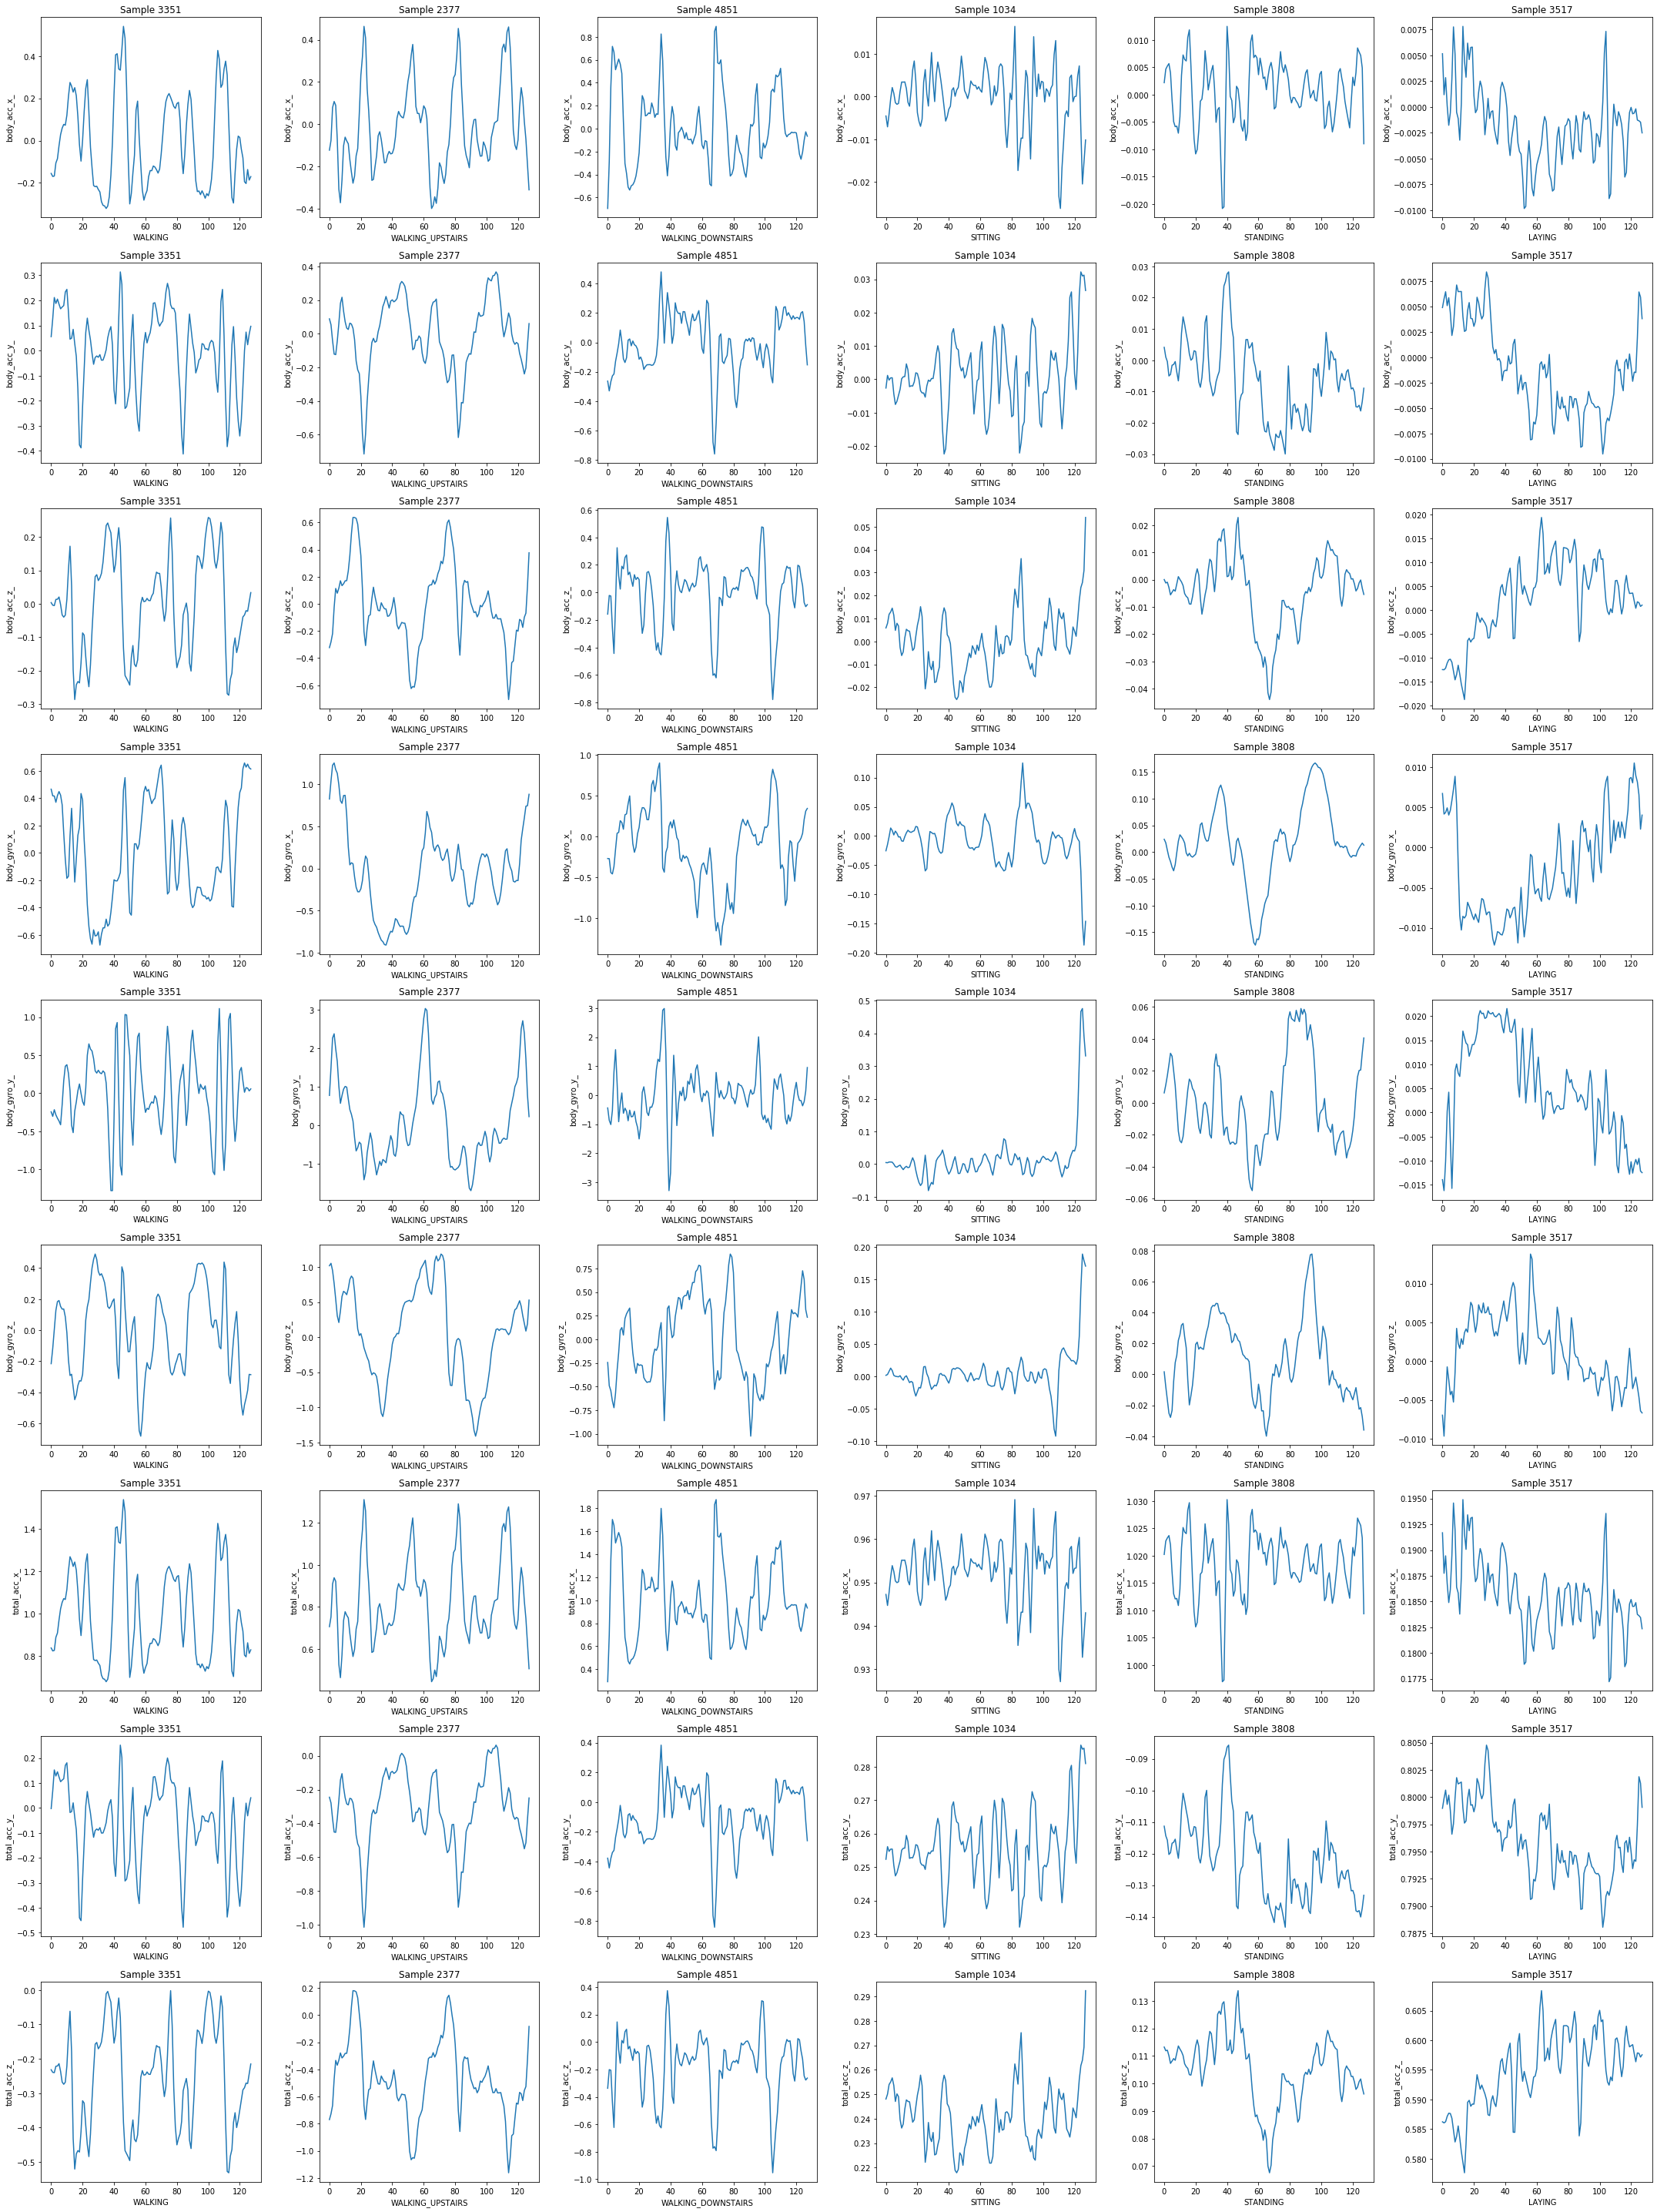

In [8]:
def plot_signals(X, y, activity_labels, seed=None):
    # get random index of each label
    np.random.seed(seed)
    ix = {}
    for i in activity_labels.keys():
        ixs_i = np.where(y == i)[0]
        ix[i] = np.random.choice(ixs_i, size=1, replace=False)[0]
    
    ix_row = np.arange(0, X.shape[1]) # signal type [0-8]
    ix_col = np.arange(0, len(activity_labels)) # labels [0-5]
    fig, ax = plt.subplots(ix_row.shape[0], ix_col.shape[0], figsize=(30,40))
    
    for i in ix_row:
        for j in ix_col:
            ax[i,j].plot(X[ix[j],i,:])
            ax[i,j].set(xlabel=activity_labels[j], ylabel=INPUT_SIGNAL_TYPES[i], title='Sample '+str(ix[j]))

    plt.tight_layout()
    plt.show()

plot_signals(X_train, y_train, activity_labels, seed=42)

It seems difficult to see relationships between the different input types from the visualization, especially since these vectors are all just sample data. However, I have a feeling that the signal similarity is more between the input types than between the different labels.

**Label Distribution**

Of course, it is of particular interest to find out what the class distribution of the target variable is. Since I am trying to find out the behavior of a person from gravity data, the balance should be guaranteed. It is also good to know, if the label distribution in the training-set is the same as in the test-set. Therefore, I analyse the label distribution of the train- and testset.

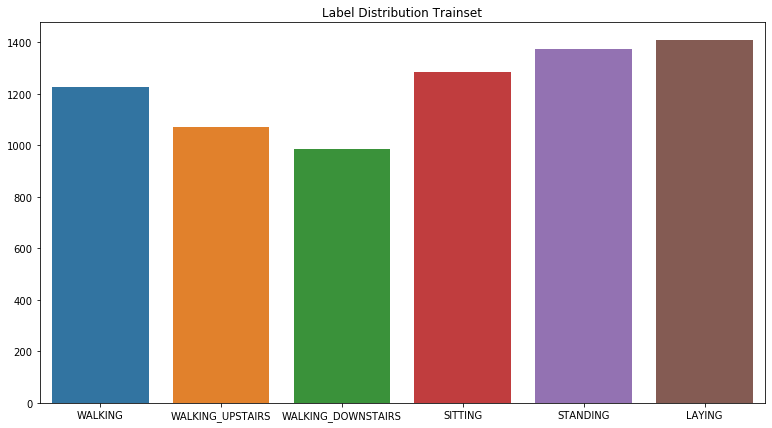

In [9]:
y_bar = pd.Series(y_train[:,0]).value_counts().sort_index()
_ = plt.figure(figsize=(13,7))
_ = sns.barplot(x=LABELS, y=y_bar)
_ = plt.title('Label Distribution Trainset')

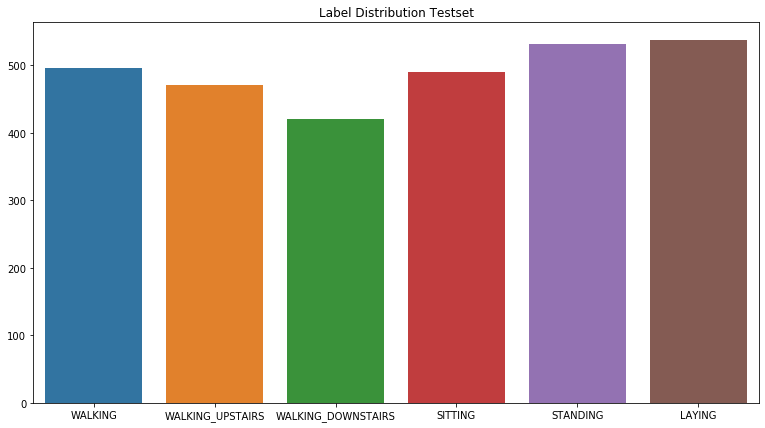

In [10]:
y_bar_test = pd.Series(y_test[:,0]).value_counts().sort_index()
_ = plt.figure(figsize=(13,7))
_ = sns.barplot(x=LABELS, y=y_bar_test)
_ = plt.title('Label Distribution Testset')

The distribution of the classes is about the same in the train and test set. The classes are reasonably well balanced. Nevertheless, the model should be trained and evaluated in a balanced way.

Because the data has already means close to zero and a relatively small standard deviation, I decide to not normalize the data. Thus, even timeframes with small gravity values, such as a frame with the label 'LAYING', usually have values close to 0. Stardscaling would affect the smaller values more than the larger ones, which I don't consider desirable.

## Model Metrics

For the evaluation of a model of a categorical target variable, different metrics are available, such as Percision, Recall, F-Score and Accuracy. Since in my view there is no real preference regarding Percision or Recall in this problem, I choose Accuracy as the target metric. Since there is also no preference between labels, and I want all labels to be treated equally, I choose the Balanced Accuracy Score. This is calculated from the average of the Accuracy of all classes. So $\frac{1}{n\_classes} \sum_{i=0}^{n\_classes} Accuracy_i$.

I will calculate the Balanced Accuracy Score on both the Train and Test sets of each Model in each epoch. In addition, I will also track the Accuracy of the Train and Test sets, but this is not the score I intend to validate the model.

## Model Setup

In [11]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from bayes_opt import BayesianOptimization
import json, os, copy, warnings

Data sets in `torch` can be included in the optimization process relatively easily with so-called `DataLoader`. To do this, the train and test datasets must be loaded into a wrapper class defined by `torch`, which must have the functions `__init__`, `_len__` and `__getitem__`. The following `ActivityRecognitionDataset` is my wrapper class.

In [12]:
class ActivityRecognitionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y).long().T[0]

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        activity = self.X[idx]
        label = self.y[idx]
        return activity, label

In [13]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/3, random_state=42, stratify=y_train)
training_data = ActivityRecognitionDataset(X_train, y_train)
test_data = ActivityRecognitionDataset(X_test, y_test)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### Model Architecture

Since there is a three-dimensional data set (samples(7352), input_type(9), timeframe(128)), the 9 `INPUT_SIGNAL_TYPES` must be appended to the timeframe. This step is done by `nn.Flatten()`. Thus the vector after this step consists of 9 x 128 units.

Since the number of hidden layers and units are actually hyperparameters to be optimized, I ran different architectures using Stochastic Gradient Descent without regularization (without code) and evaluated them with respect to balanced accuracy score of the test set (numbers describe number of units of the linear layer):
- Input -> 1000 -> 900 -> Output = 0.87
- Input -> 1000 -> Output = 0.87
- Input -> 200 -> Output = 0.86
- Input -> 800 -> 400 -> 200 -> 50 -> Output = 0.86
- Input -> 800 -> 800 -> 800 -> Output = 0.87

It can be seen that shallow & deep, wide remaining and narrowing architectures have a comparable balanced accuracy score. Since this was done only on the SGD optimizer without regularization (as well as the MC is about Deep Learning), I decide to use the last architecture mentioned above: --Input -> 800 -> 800 -> 800 -> Output-- (wide remaining architecture was slightly better).

The model weights are initialized per linear layer $i$ as follows:

$\sigma_i = \frac{1}{\sqrt{\text{weight.size(dim=1)}_i}}$

Then, the weights (including bias) are randomly initialized from a uniform distribution in the interval $[-\sigma_i, +\sigma_i]$.

In [14]:
torch.manual_seed(42)
network = nn.Sequential(
    nn.Flatten(),
    nn.Linear(n_flatten, 800),
    nn.ReLU(),
    nn.Linear(800, 800),
    nn.ReLU(),
    nn.Linear(800, 800),
    nn.ReLU(),
    nn.Linear(800, 800),
    nn.ReLU(),
    nn.Linear(800, n_output)
)

network.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1152, out_features=800, bias=True)
  (2): ReLU()
  (3): Linear(in_features=800, out_features=800, bias=True)
  (4): ReLU()
  (5): Linear(in_features=800, out_features=800, bias=True)
  (6): ReLU()
  (7): Linear(in_features=800, out_features=800, bias=True)
  (8): ReLU()
  (9): Linear(in_features=800, out_features=6, bias=True)
)

### Train- and Test Loops

CrossEntropyLoss is defined as the cost function, since we have a classification problem. Since only one class is considered true at a time, the vector is previously normalized to a sum of 1 using a softmax layer. `nn.CrossEntropyLoss` contains both functions, Softmax as well as CrossEntropyLoss. Among other things probably also because the derivation of the two layers together is very compact.

In `train_loop` the training of the model takes place. With the help of `dataloader` we can iterate over the dataset using mini-batches. First the forwardpropagation is done by `model(X)` call. Then the CrossEntropyLoss is calculated using `loss_fn`.  Since `torch` does not support L1 regularization, it must be done manually here if `reg`=='l1' (L2 regularization is defined in `optimizer`). After forwardpropagation all metrics are calculated before the error is backpropagated. Once all iterations are through, the metrics are logged in `Tensorboard` to visualize the progress of the epochs. 

In `test_loop` the different metrics for the training set are calculated. It is important to mention here that the model is in evaluation mode. This means that dropout and batchnorm are not applied in the same way as in training. Afterwards, the metrics are logged in `Tensorboard` as in `train_loop`.

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer, device, n_model, n_iter, writer, reg, reg_param):
    train_loss, correct, bas = 0, 0, 0
    
    for X, y in dataloader:
        model.train() # enables Dropout and Batchnorm
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
            
        # Implements l1_regularization (l1 after Compute Accuracy to not have regularization term in loss observation on TensorBoard)
        if reg == 'l1':
            l1_reg = torch.tensor(0.).to(device)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_reg += torch.norm(param, 1)
            loss += (reg_param / X.shape[0]) * l1_reg
            
        with torch.no_grad():
            minibatch_ratio = X.shape[0] / dataloader.batch_size # is always 1, except for the last mini-batch to adjust loss weight
            train_loss += loss.item() * minibatch_ratio # * minibatch_ratio because the `loss_fn` is set to 'mean'
            pred_classes = logits.argmax(1)
            correct += (pred_classes == y).type(torch.float).sum().item()
            with warnings.catch_warnings(): # catches "y_pred contains classes not in y_true"
                warnings.filterwarnings('ignore', category=UserWarning)
                bas += balanced_accuracy_score(y.cpu(), pred_classes.cpu()) * minibatch_ratio # upscaling because the last mini-batch is likely to have a different size

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(dataloader) # scale test loss to adjust summation in mini-batch loop
    correct /= len(dataloader.dataset)
    bas /= len(dataloader)
    writer.add_scalar('model_'+str(n_model)+'/loss_train', train_loss, n_iter)
    writer.add_scalar('model_'+str(n_model)+'/accuracy_train', correct, n_iter)
    writer.add_scalar('model_'+str(n_model)+'/balanced_accuracy_train', bas, n_iter)
    return train_loss, correct, bas

def test_loop(dataloader, model, loss_fn, n_model, n_iter, writer):
    test_loss, correct, bas = 0, 0, 0
    model.eval() # disables dropout and batchnorm

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            minibatch_ratio = X.shape[0] / dataloader.batch_size # is always 1, except for the last mini-batch to adjust test_loss weight
            test_loss += loss_fn(logits, y).item() * minibatch_ratio
            pred_classes = logits.argmax(1)
            correct += (pred_classes == y).type(torch.float).sum().item()
            with warnings.catch_warnings(): # catches "y_pred contains classes not in y_true"
                warnings.filterwarnings('ignore', category=UserWarning)
                bas += balanced_accuracy_score(y.cpu(), pred_classes.cpu()) * minibatch_ratio # scaling up because the last mini-batch is likely to have a different size

    test_loss /= len(dataloader) # scale test loss to adjust summation in mini-batch loop
    correct /= len(dataloader.dataset)
    bas /= len(dataloader)
    writer.add_scalar('model_'+str(n_model)+'/loss_test', test_loss, n_iter)
    writer.add_scalar('model_'+str(n_model)+'/accuracy_test', correct, n_iter)
    writer.add_scalar('model_'+str(n_model)+'/balanced_accuracy_test', bas, n_iter)
    return test_loss, correct, bas

### Hyperparameter Tuning

Now the task is to find a good model in terms of balanced accuracy score of the test set. The following models are evaluated:

- Stochastic Gradient Descent without regularization
- Stochastic Gradient Descent with L1 regularization
- Stochastic Gradient Descent with L2 regularization
- Stochastic Gradient Descent with Dropout regularization
- Stochastic Gradient Descent without regularization with Batchnorm
- Adam without regularization
- Adam with L1 regularization
- Adam with L2 regularization
- Adam with Dropout Regularization

In order to evaluate the best possible models in terms of hyperparameter selection, I performed a Bayesian search with respect to the balanced accuracy score of the test set. The selection of the hyperparameters of the first models per model type are chosen randomly in the defined interval. After that, the `BayesianOptimizer` decides the future selection of hyperparameters. I have also set up an early stopping, that if the balanced accuracy score of the test set does not improve over a certain number of epochs, that the training is then stopped due to time constraints. This might be not the best solution since it is possible that a model can even get better after more then the specified 50 epochs of not improving. But since the hyperparameter tuning consumes a lot of time, I decided to continue with this approach. I also save the best model of each model type under the folder 'networks', so that they can theoretically be reloaded later.

The metrics (accuracy_train, accuracy_test, balanced_accuracy_train, balanced_accuracy_test, train_loss, test_loss) of the different runs are visualized using `Tensorboard` to be able to follow the results in real time. The x-axis shows the epoch, where the y-axis the according metric score. Also the hyperparameters are logged in `Tensorboard` along with the metrics of the best model of the current run. The data is stored in the 'runs' folder. Thus it is relatively easy to pick out the best model with the best parameters. `Tensorboard` can be accessed as soon as the server is started on localhost with: "tensorboard --logdir=runs". The models on `Tensorboard` are stored from model_0 to model_19. So if you intend to get the according metric visualization of e.g. model 3 of `BayesianOptimizer`, you have to look at model_2 on `Tensorboard`. If u run a hyperparameter search again, you also have to delete the according folder in the 'runs' directory.

In `fit_MLP`, 'reg_param' is the respective hyperparameter of the regularization. So 'reg_param' is $\lambda$ in L1 and L2 and *dropout_rate* in dropout.

In [16]:
def storage_manager(optimization, reg, params, best_dict):
    folder = './networks'
    filename = folder+'/'+optimization+'_'+str(reg)
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    store = False
    if os.path.exists(filename+'.json'): # could be either .pth or .json
        with open(filename+'.json') as fp:
            loaded_params = json.load(fp)
        if best_dict['test_bacc'] > loaded_params['test_bacc']:
            store = True
    else:
        store = True
    
    if store:
        torch.save(best_dict['best_state'], filename+'.pth')
        best_dict.pop('best_state') # drops best_state because Tensor is not JSON serializable
        best_params = {**params,**best_dict}
        with open(filename+'.json', 'w') as fp:
            json.dump(best_params, fp)

def setup_ts_writer(optimization, reg, batchnorm):
    """Generates a new SummaryWriter"""
    path = './runs/'+optimization+'_'+str(reg)
    if batchnorm:
        path += '_batchnorm'
    writer = SummaryWriter(path)
    return writer

def add_batch_norm(network, device):
    """Adds Batchnorm layer before the ReLU activation function"""
    layers = []
    for i, layer in enumerate(network):
        if isinstance(layer, type(nn.ReLU())):
            layers.append(nn.BatchNorm1d(network[i-1].out_features))
        layers.append(layer)
    return nn.Sequential(*layers).to(device)

def add_dropout(network, dropout_rate, device):
    """Adds Dropout layer after the ReLU activation function"""
    layers = []
    for layer in network:
        layers.append(layer)
        if isinstance(layer, type(nn.ReLU())):
            layers.append(nn.Dropout(p=dropout_rate))
    return nn.Sequential(*layers).to(device)

def fit_MLP(network_init, dtrain, dtest, optimization, reg, batchnorm, epochs, params): # dtest should be a validation, not test set
    network_init = copy.deepcopy(network_init)
    sample_weights = compute_sample_weight(class_weight='balanced', y=dtrain.y)
    weighted_sampler = WeightedRandomSampler(sample_weights, len(sample_weights)) # adresses balanced training through train DataLoader
    writer = setup_ts_writer(optimization, reg, batchnorm) # writer setup for TensorBoard
    loss_fn = nn.CrossEntropyLoss() # combines Softmax and Cross Entropy, default 'means' error
    best_dict = {'test_bacc':0}
    n_model = {'n_model':0}
    early_stopping_epochs = 50 # number of epochs allowed without improving of balanced accuracy score of the test set
    
    if reg==None:
        params.pop('reg_param', None) # ensures that reg_param is out of `param` so it will not be tuned in `BayesianOptimization`
    
    if batchnorm:
        network_init = add_batch_norm(network_init, device) # global variable `device`
    
    def train_MLP(learning_rate, batch_size, reg_param=None):
        local_best_dict = {'test_bacc':0}
        batch_size = int(batch_size) # cast to int because BayesianOptimization doesn't allow discrete parameter optim specificly
        train_dataloader = DataLoader(dtrain, batch_size=batch_size, sampler=weighted_sampler) # if sampler is active, `shuffler` must be disabled
        test_dataloader = DataLoader(dtest, batch_size=1024) # batch_size of test_dataloader is just to prevent memory errors
        network = copy.deepcopy(network_init) # deepcopy to ensure, that the model weights are not altered from previous run
        early_stopping_iter = 0
        
        if reg=='l2':
            optimizers = {'sgd':torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=reg_param),
                          'adam':torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=reg_param)}
        elif (reg=='dropout') or (reg=='l1') or (reg==None):
            if reg=='dropout': # in dropout is `reg_param` is dropout_rate
                network = add_dropout(network, reg_param, device) # global variable device
            optimizers = {'sgd':torch.optim.SGD(network.parameters(), lr=learning_rate),
                          'adam':torch.optim.Adam(network.parameters(), lr=learning_rate)}
        optimizer = optimizers[optimization]
        
        for n_iter in range(epochs):
            J_train, train_acc, train_bacc = train_loop(train_dataloader, network, loss_fn, optimizer, device, n_model['n_model'], n_iter, writer, reg, reg_param)
            J_test, test_acc, test_bacc = test_loop(test_dataloader, network, loss_fn, n_model['n_model'], n_iter, writer)
            
            if np.isnan(J_train) and np.isnan(J_test):
                local_best_dict['test_bacc'] = 0
                break # no further training on this weights possible
                
            if test_bacc > local_best_dict['test_bacc']: # update local best run
                early_stopping_iter = 0
                local_best_dict['train_acc'] = train_acc
                local_best_dict['test_acc'] = test_acc
                local_best_dict['train_bacc'] = train_bacc
                local_best_dict['test_bacc'] = test_bacc
                local_best_dict['train_loss'] = J_train
                local_best_dict['test_loss'] = J_test
                local_best_dict['epochs'] = n_iter
                if local_best_dict['test_bacc'] > best_dict['test_bacc']: # update global best run
                    # can't use {**best_dict,**local_best_dict} because this returns a new object which is just a local reference
                    best_dict['train_acc'] = train_acc
                    best_dict['test_acc'] = test_acc
                    best_dict['train_bacc'] = train_bacc
                    best_dict['test_bacc'] = test_bacc
                    best_dict['train_loss'] = J_train
                    best_dict['test_loss'] = J_test
                    best_dict['best_state'] = network.state_dict()
            else: # early stopping
                early_stopping_iter += 1
                if early_stopping_iter >= early_stopping_epochs:
                    break
                    
        writer.add_hparams({'lr':learning_rate, 'bsize':batch_size, 'rparam':reg_param, 'epochs':local_best_dict['epochs']+1},
                           {'hparams/train_acc':local_best_dict['train_acc'], 'hparams/test_acc':local_best_dict['test_acc'],
                            'hparams/train_bacc':local_best_dict['train_bacc'], 'hparams/test_bacc':local_best_dict['test_bacc'],
                            'hparams/train_loss':local_best_dict['train_loss'], 'hparams/test_loss':local_best_dict['test_loss']},
                           run_name=optimization+'_'+str(reg)+'_model_'+str(n_model['n_model']))
        n_model['n_model'] = n_model['n_model'] + 1
        return local_best_dict['test_bacc']
    
    bayesian_optimizer = BayesianOptimization(
        f=train_MLP,
        pbounds=params,
        random_state=42,
        verbose=2)
    bayesian_optimizer.maximize(n_iter=14,init_points=6)
    best_params = bayesian_optimizer.max['params']
    
    best_dict['structure'] = [str(layer) for layer in list(network_init)] # stores network structure
    storage_manager(optimization, reg, best_params, best_dict)

In [23]:
#!pip install tensorboard
#!tensorboard --logdir=runs

#### Stochastic Gradient Descent without Regularization

In [17]:
params_sgd_noReg = {'learning_rate':(.001,.15),'batch_size':(32,512)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='sgd', reg=None, batchnorm=False, epochs=500, params=params_sgd_noReg)

|   iter    |  target   | batch_... | learni... |
-------------------------------------------------
|  1        |  0.8717   |  211.8    |  0.1427   |
|  2        |  0.8669   |  383.4    |  0.0902   |
|  3        |  0.8406   |  106.9    |  0.02424  |
|  4        |  0.8572   |  59.88    |  0.1301   |
|  5        |  0.8593   |  320.5    |  0.1065   |
|  6        |  0.8515   |  41.88    |  0.1455   |
|  7        |  0.8642   |  234.0    |  0.07579  |
|  8        |  0.8598   |  212.9    |  0.05241  |
|  9        |  0.8372   |  211.2    |  0.02534  |
|  10       |  0.8644   |  34.71    |  0.0701   |
|  11       |  0.8636   |  352.4    |  0.09669  |
|  12       |  0.8509   |  47.59    |  0.03307  |
|  13       |  0.855    |  244.1    |  0.1238   |
|  14       |  0.8598   |  40.94    |  0.06631  |
|  15       |  0.8632   |  221.7    |  0.07362  |
|  16       |  0.8271   |  363.3    |  0.01924  |
|  17       |  0.84     |  321.9    |  0.0236   |
|  18       |  0.8463   |  412.5    |  0.1327   |


<img src="./images/sgd_None.PNG" width=1000 align="left">

The best model achieves a balanced accuracy score of 0.87 on the test set with an lr of 0.14266 and a batch size of 211. Specifically, the largest decrease in the loss function occurs within the first 20 epochs. After that, the train loss continues to decrease, but the test loss starts to increase. This is despite the fact that the balanced accuracy score on the training and test set remains the same or even improves (up to epoch 80). The model seems to overfit, as the accuracy on the trainset is greater than on the test set.

#### Stochastic Gradient Descent with L1 Regularization

In [25]:
params_sgd_l1 = {'learning_rate':(.001,.15),'batch_size':(32,512),'reg_param':(.001,.05)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='sgd', reg='l1', batchnorm=False, epochs=500, params=params_sgd_l1)

|   iter    |  target   | batch_... | learni... | reg_param |
-------------------------------------------------------------
|  1        |  0.8346   |  211.8    |  0.1427   |  0.03687  |
|  2        |  0.8364   |  319.4    |  0.02425  |  0.008644 |
|  3        |  0.602    |  59.88    |  0.1301   |  0.03045  |
|  4        |  0.5942   |  371.9    |  0.004067 |  0.04853  |
|  5        |  0.8547   |  431.6    |  0.03264  |  0.009909 |
|  6        |  0.8466   |  120.0    |  0.04633  |  0.02671  |
|  7        |  0.8338   |  430.1    |  0.02943  |  0.04055  |
|  8        |  0.8553   |  445.5    |  0.1414   |  0.005241 |
|  9        |  0.8522   |  139.5    |  0.1021   |  0.01802  |
|  10       |  0.8597   |  160.4    |  0.04232  |  0.01124  |
|  11       |  0.8448   |  181.8    |  0.1458   |  0.02921  |
|  12       |  0.8043   |  295.8    |  0.01436  |  0.04234  |
|  13       |  0.8282   |  235.3    |  0.15     |  0.05     |
|  14       |  0.819    |  260.0    |  0.006487 |  0.0264   |
|  15   

<img src="./images/sgd_l1.PNG" width=1000 align="left">

The best model achieves a balanced accuracy score of 0.86 on the test set with an lr of 0.063424, a batch size of 171 and $\lambda$ = 0.022233. Here, accuracy and balanced accuracy increase the most for the first 20 epochs. The differences in the train and test loss can be explained by the fact that regularization was not included in the test loss. The balanced accuracy score on the testset as well as the test loss do not seem to improve after about 100 epochs. The accuracy on the trainset is still greater than that of the testset. The model still seems to overfit. However, looking at the other 19 iterations, I see that increasing the regularization parameter $\lambda$ even causes a massive deterioration of the balanced accuracy score. Thus, the L1 regularization does not seem to have the desired effect.

#### Stochastic Gradient Descent with L2 Regularization

In [26]:
params_sgd_l2 = {'learning_rate':(.001,.15),'batch_size':(32,512),'reg_param':(.001,.05)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='sgd', reg='l2', batchnorm=False, epochs=500, params=params_sgd_l2)

|   iter    |  target   | batch_... | learni... | reg_param |
-------------------------------------------------------------
|  1        |  0.4787   |  211.8    |  0.1427   |  0.03687  |
|  2        |  0.8393   |  319.4    |  0.02425  |  0.008644 |
|  3        |  0.7478   |  59.88    |  0.1301   |  0.03045  |
|  4        |  0.5141   |  371.9    |  0.004067 |  0.04853  |
|  5        |  0.8328   |  431.6    |  0.03264  |  0.009909 |
|  6        |  0.8339   |  120.0    |  0.04633  |  0.02671  |
|  7        |  0.8529   |  320.7    |  0.05527  |  0.009407 |
|  8        |  0.7505   |  456.3    |  0.02686  |  0.02573  |
|  9        |  0.6073   |  96.34    |  0.001    |  0.001    |
|  10       |  0.8265   |  138.0    |  0.006612 |  0.003667 |
|  11       |  0.4809   |  338.5    |  0.15     |  0.05     |
|  12       |  0.8009   |  128.9    |  0.15     |  0.01865  |
|  13       |  0.8275   |  418.0    |  0.01606  |  0.002181 |
|  14       |  0.8534   |  153.8    |  0.1085   |  0.001461 |
|  15   

<img src="./images/sgd_l2.PNG" width=1000 align="left">

The best model achieves a balanced accuracy score of 0.85 on the test set with an lr of 0.10852, a batch-size of 153 and $\lambda$ = 0.0014607. Again, accuracy and balanced accuracy increase the most for the first 20 epochs. The accuracy as well as the balanced accuracy hardly seems to improve after about 50 epochs. As with the previous models, the train accuracy is higher than the test accuracy, implying an overfitting. And again, as with L1 regularization, increasing $\lambda$ only seems to give worse results. Maybe it is just bad luck that the right combination of $\lambda$, batch-size and lr was not found in the 20 iterations. Thus, the L2 regularization does not seem to bring the desired effect either.

The lower values of the L2 train loss compared to the L1 train loss let me assume that the `Optimizer` performs the weight decay at the backpropagation, but does not output it at `nn.CrossEntroyLoss`, which makes tracking the loss function with the L2 regularization difficult. Furthermore, `torch` L2 regularization makes the weight decay also on the bias weights. I have not seen an easy way to apply this only on input weights, as long as I want to use the weight decay of the `Optimizer`.

#### Stochastic Gradient Descent with Dropout Regularization

In [27]:
params_sgd_dropout = {'learning_rate':(.001,.15),'batch_size':(32,512),'reg_param':(.1,.4)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='sgd', reg='dropout', batchnorm=False, epochs=500, params=params_sgd_dropout)

|   iter    |  target   | batch_... | learni... | reg_param |
-------------------------------------------------------------
|  1        |  0.8688   |  211.8    |  0.1427   |  0.3196   |
|  2        |  0.8494   |  319.4    |  0.02425  |  0.1468   |
|  3        |  0.8707   |  59.88    |  0.1301   |  0.2803   |
|  4        |  0.484    |  371.9    |  0.004067 |  0.391    |
|  5        |  0.8522   |  431.6    |  0.03264  |  0.1545   |
|  6        |  0.8677   |  120.0    |  0.04633  |  0.2574   |
|  7        |  0.873    |  61.67    |  0.1111   |  0.325    |
|  8        |  0.8713   |  269.5    |  0.06019  |  0.1617   |
|  9        |  0.8326   |  482.2    |  0.01603  |  0.1719   |
|  10       |  0.5853   |  166.3    |  0.001    |  0.1      |
|  11       |  0.8867   |  239.9    |  0.1053   |  0.3936   |
|  12       |  0.8734   |  94.43    |  0.08582  |  0.1335   |
|  13       |  0.8664   |  512.0    |  0.15     |  0.1      |
|  14       |  0.8816   |  295.2    |  0.1485   |  0.3515   |
|  15   

<img src="./images/sgd_dropout.PNG" width=1000 align="left">

Dropout regularization seems to achieve the best result so far of a balanced accuracy score of 0.89 on the testset with an lr of 0.1053, a batch-size of 239 and dropout rate of 0.3936. As before, the first 20 epochs are the most efficient in terms of training. Metrics do not seem to vary through the epochs as much as in the other models. Despite a new peak in the target metric, the train accuracy is also higher than the test set. The best models also have a dropout rate close to 0.4, which is the upper maximum of the given range. Perhaps an even better score would have been possible if the dropout rate had been a bit higher.

#### Stochastic Gradient Descent without Regularization with Batchnorm

In [18]:
params_sgd_batchnorm = {'learning_rate':(.001,.15),'batch_size':(32,512)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='sgd', reg=None, batchnorm=True, epochs=500, params=params_sgd_batchnorm)

|   iter    |  target   | batch_... | learni... |
-------------------------------------------------
|  1        |  0.8653   |  211.8    |  0.1427   |
|  2        |  0.8596   |  383.4    |  0.0902   |
|  3        |  0.862    |  106.9    |  0.02424  |
|  4        |  0.8806   |  59.88    |  0.1301   |
|  5        |  0.857    |  320.5    |  0.1065   |
|  6        |  0.8848   |  41.88    |  0.1455   |
|  7        |  0.8564   |  512.0    |  0.15     |
|  8        |  0.8885   |  40.97    |  0.1089   |
|  9        |  0.8883   |  36.74    |  0.05566  |
|  10       |  0.8871   |  68.2     |  0.108    |
|  11       |  0.8598   |  75.47    |  0.15     |
|  12       |  0.8808   |  64.53    |  0.08935  |
|  13       |  0.8779   |  52.77    |  0.03651  |
|  14       |  0.8531   |  447.4    |  0.01839  |
|  15       |  0.8547   |  265.1    |  0.01967  |
|  16       |  0.862    |  159.9    |  0.03624  |
|  17       |  0.862    |  414.8    |  0.1466   |
|  18       |  0.8867   |  32.0     |  0.05528  |


<img src="./images/sgd_None_batchnorm.PNG" width=1000 align="left">

The best model with the SGD oprimizer without regularization but with batch normalization achieved a balanced accuracy score of 0.89 on the test set. This was achieved with an lr of 0.1089 and a batch size of 40. This is comparable to the best model of SGD including dropout. Unlike there, the metrics on the testset vary greatly through the epochs.  As with previous trainings, there is an increase in test loss after about 20 epochs. However, unlike the previous models, the balanced accuracy no longer increases after about 20 epochs. The model has therefore adapted the parameters extremely quickly, and further training does not really lead to an improvement in the target metric on the test set.

#### Adam without Regularization

In [29]:
params_adam_noReg = {'learning_rate':(.0001,.005),'batch_size':(32,512)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='adam', reg=None, batchnorm=False, epochs=800, params=params_adam_noReg)

|   iter    |  target   | batch_... | learni... |
-------------------------------------------------
|  1        |  0.8699   |  211.8    |  0.004759 |
|  2        |  0.8713   |  383.4    |  0.003033 |
|  3        |  0.8719   |  106.9    |  0.000864 |
|  4        |  0.8599   |  59.88    |  0.004344 |
|  5        |  0.8636   |  320.5    |  0.00357  |
|  6        |  0.8662   |  41.88    |  0.004853 |
|  7        |  0.8708   |  119.0    |  0.002431 |
|  8        |  0.8724   |  105.6    |  0.003672 |
|  9        |  0.8731   |  90.84    |  0.00498  |
|  10       |  0.8672   |  408.5    |  0.004737 |
|  11       |  0.8712   |  144.5    |  0.001562 |
|  12       |  0.8714   |  171.5    |  0.002562 |
|  13       |  0.8693   |  362.5    |  0.004374 |
|  14       |  0.8689   |  245.7    |  0.001519 |
|  15       |  0.8619   |  512.0    |  0.001142 |
|  16       |  0.8745   |  190.3    |  0.002205 |
|  17       |  0.8608   |  455.5    |  0.004374 |
|  18       |  0.8632   |  276.1    |  0.000887 |


<img src="./images/adam_None.PNG" width=1000 align="left">

The best model with the Adam optimizer without regularization achieves a balanced accuracy score of 0.88. This was achieved with an lr of 0.000643 and a batch-size of 198. Unlike SGD, the lr must be set much lower. It can be observed that the training loss decreases quite well over the epochs. The test loss, on the other hand, increases continuously over the course of the training, as is the case with other models. The accuracy of the trainset increases steadily, but the accuracy of the test set does not. The high accuracy on the trainset suggests an overfitting.

#### Adam with L1 Regularization

In [30]:
params_adam_l1 = {'learning_rate':(.0001,.005),'batch_size':(32,512),'reg_param':(.001,.05)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='adam', reg='l1', batchnorm=False, epochs=800, params=params_adam_l1)

|   iter    |  target   | batch_... | learni... | reg_param |
-------------------------------------------------------------
|  1        |  0.8685   |  211.8    |  0.004759 |  0.03687  |
|  2        |  0.8515   |  319.4    |  0.000864 |  0.008644 |
|  3        |  0.1599   |  59.88    |  0.004344 |  0.03045  |
|  4        |  0.8415   |  371.9    |  0.000200 |  0.04853  |
|  5        |  0.8608   |  431.6    |  0.00114  |  0.009909 |
|  6        |  0.8491   |  120.0    |  0.001591 |  0.02671  |
|  7        |  0.8641   |  229.1    |  0.001234 |  0.007682 |
|  8        |  0.7696   |  209.9    |  0.000887 |  0.03651  |
|  9        |  0.8594   |  219.8    |  0.004138 |  0.02058  |
|  10       |  0.8623   |  419.9    |  0.002291 |  0.03077  |
|  11       |  0.8589   |  240.8    |  0.004722 |  0.01728  |
|  12       |  0.8603   |  407.8    |  0.002726 |  0.02399  |
|  13       |  0.845    |  395.9    |  0.00087  |  0.03906  |
|  14       |  0.8645   |  383.8    |  0.003104 |  0.005436 |
|  15   

<img src="./images/adam_l1.PNG" width=1000 align="left">

The best model with the Adam optimizer achieves a balanced accuracy score of 0.87 (slightly better than Adam without regularization). This was achieved with a lr of 0.003873, a batch-size of 464 and $\lambda$ of 0.01056. The target metrics of the test set seem to vary less than Adam without regularization. Nevertheless, the exact same effect is visible here. Fast training after a few epochs without a significant improvement afterwards regarding the target metrics on the testset. However, I can imagine that perhaps a better optimum could be found here if the early stopping had not turned on. However, I doubt a significant improvement, since again the apparent overfitting cannot be solved by L1 regularization (assuming that the range of $\lambda$ was well chosen). I can imagine that a larger $\lambda$ could have led to better results.

#### Adam with L2 Regularization

In [31]:
params_adam_l2 = {'learning_rate':(.0001,.005),'batch_size':(32,512),'reg_param':(.001,.05)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='adam', reg='l2', batchnorm=False, epochs=800, params=params_adam_l2)

|   iter    |  target   | batch_... | learni... | reg_param |
-------------------------------------------------------------
|  1        |  0.7876   |  211.8    |  0.004759 |  0.03687  |
|  2        |  0.8469   |  319.4    |  0.000864 |  0.008644 |
|  3        |  0.7537   |  59.88    |  0.004344 |  0.03045  |
|  4        |  0.7379   |  371.9    |  0.000200 |  0.04853  |
|  5        |  0.8426   |  431.6    |  0.00114  |  0.009909 |
|  6        |  0.747    |  120.0    |  0.001591 |  0.02671  |
|  7        |  0.8359   |  318.2    |  0.002137 |  0.0157   |
|  8        |  0.7564   |  326.5    |  0.002645 |  0.02138  |
|  9        |  0.8417   |  435.4    |  0.000508 |  0.01272  |
|  10       |  0.8422   |  425.8    |  0.002706 |  0.01325  |
|  11       |  0.7763   |  419.7    |  0.000914 |  0.01909  |
|  12       |  0.7704   |  441.2    |  0.004958 |  0.04867  |
|  13       |  0.8068   |  307.2    |  0.004203 |  0.02868  |
|  14       |  0.8519   |  428.5    |  0.003767 |  0.008751 |
|  15   

<img src="./images/adam_l2.PNG" width=1000 align="left">

The best model with an Adam optimizer including L2 regularization achieved a balanced accuracy score of 0.87. This was achieved with an lr of 0.004093, a batch-size of 511 and $\lambda$ of 0.001195. Again, the same pattern as the previous model is observed. Very fast training with no subsequent significant improvement with respect to the target metric on the testset. L2 regularization can thus not really address the problem of overfitting either, assuming that the range of hyperparameters is reasonably well chosen (higher $\lambda$ lead to a deterioration of the target metric).

#### Adam with Dropout Regularization

In [32]:
params_adam_dropout = {'learning_rate':(.0001,.005),'batch_size':(32,512),'reg_param':(.1,.4)}
fit_MLP(network_init=network, dtrain=training_data, dtest=test_data, optimization='adam', reg='dropout', batchnorm=False, epochs=800, params=params_adam_dropout)

|   iter    |  target   | batch_... | learni... | reg_param |
-------------------------------------------------------------
|  1        |  0.8783   |  211.8    |  0.004759 |  0.3196   |
|  2        |  0.8729   |  319.4    |  0.000864 |  0.1468   |
|  3        |  0.8702   |  59.88    |  0.004344 |  0.2803   |
|  4        |  0.8657   |  371.9    |  0.000200 |  0.391    |
|  5        |  0.8692   |  431.6    |  0.00114  |  0.1545   |
|  6        |  0.8854   |  120.0    |  0.001591 |  0.2574   |
|  7        |  0.8746   |  144.0    |  0.004712 |  0.2766   |
|  8        |  0.8808   |  119.1    |  0.00137  |  0.2755   |
|  9        |  0.8717   |  121.4    |  0.000263 |  0.288    |
|  10       |  0.8717   |  119.8    |  0.000852 |  0.13     |
|  11       |  0.8836   |  461.2    |  0.004321 |  0.224    |
|  12       |  0.8838   |  191.5    |  0.003432 |  0.3889   |
|  13       |  0.8873   |  77.33    |  0.004026 |  0.2787   |
|  14       |  0.8881   |  225.5    |  0.004219 |  0.3273   |
|  15   

<img src="./images/adam_dropout.PNG" width=1000 align="left">

Finally, the Adam optimizer with dropout regularization is applied. The best model achieves a balanced accuracy score of 0.88 on the test set. This was achieved with an lr of 0.004219, batch-size of 225 and a dropout rate of 0.3273. Here, too, an extremely fast training is evident. It is special that the test loss is already after one epoch on the minimum (I assume that it is coincidence, because I always make a copy of the object right at the beginning to prevent changes of the object within the function). Otherwise, the same pattern can be seen as with the other Adam optimizer models. Extremely fast training followed by fluctuating values of the target metric on the testset. Specifically, it should be mentioned here that virtually all iterations yield comparably good models. Since the model still overfits, I assume that, as with SGD, the dropout rate could be increased to achieve a better result.

#### Hyperparameter Overview

<img src="./images/hyperparams.PNG" width=1000 align="left">

`Tensorboard` also provides a good overview of the hyperparameters and target metrics of the different test runs. In the table view I sorted the results by the target metric. It is easy to see that the best models come from the SGD optimizer including the batchnorm and the dropout regularization models. These have a balanced accuracy score of almost 0.89 on the test set.

## Conclusion

The best models achieved a balanced accuracy score of almost 0.89 on the test set. In my opinion, these performed well for an MLP architecture. However, the test set was used as a validation set. So if you had another test set, the score would most likely be a little bit lower.

Strikingly, no regularization method addressed overfitting as well as I would have liked. Still, the dropout approaches gave promising results and the best models came from those trained without regularization but with batchnorm. Perhaps the problem could have been better addressed with a narrower model architecture.

Furthermore, all model types learned very quickly, with the Adam optimizer appearing even faster. Often after that, the early stopping of 50 iterations with no improvement on the target metric stopped the training pretty quickly. I think that if one were to babysit a model, the balanced accuracy score could even be driven above 0.9. 

In many training cycles it was noticeable that after 10-20 epochs the test loss starts to increase. I think that after a few epochs the model has already learned the basic structure. However, the cost function CrossEntropyLoss only considers the error where the label is also True. Thus, it is possible that the other outputs are increased even though the True label is still the argmax. This could explain the improvement in the target metric for many models, even though the test loss increased at the same time.